In [1]:
%%time
# Imports
from utils import *

CPU times: total: 1.42 s
Wall time: 8.96 s


File-Reading

In [2]:
%%time

# Get start time
start = time.perf_counter()

# File-Reading
path = os.path.join(os.getcwd() , out_file) # from utils
user = []
ts = []
# ca = []
tweets = []
mentions = []
# coord = []
country = []

with open(path , 'r' , encoding='utf-8') as in_file:
    csv_reader = csv.reader(in_file , delimiter = "|")
    for line in csv_reader:
        user.append(line[0])
        # ts.append(line[1])
        # ca.append(line[2])
        tweets.append(line[3])
        mentions.append(line[4])
        # coord.append(line[5])
        country.append(line[6])

CPU times: total: 26.9 s
Wall time: 27.9 s


In [3]:
%%time
# Convert timestamp to datetime format
ts_convert = [datetime.datetime.fromtimestamp(int(dt)//1000) for dt in ts]

# twt_df = pd.DataFrame(
#     list(zip(user , ts_convert , tweets)) , columns = ['user' , 'ts' , 'tweet_id']
# )

# twt_df = twt_df[twt_df['tweet_id']!="None"].drop_duplicates()
# print(f'length of tweet df is {len(twt_df)}')

CPU times: total: 0 ns
Wall time: 0 ns


# **02 - USERS**
### **Question - 1**

In [5]:
%%time
twt_df_usr = twt_df.groupby('user').agg(num_twt = ('tweet_id' , 'nunique')).reset_index()

CPU times: total: 21.7 s
Wall time: 21.7 s


CPU times: total: 141 ms
Wall time: 170 ms


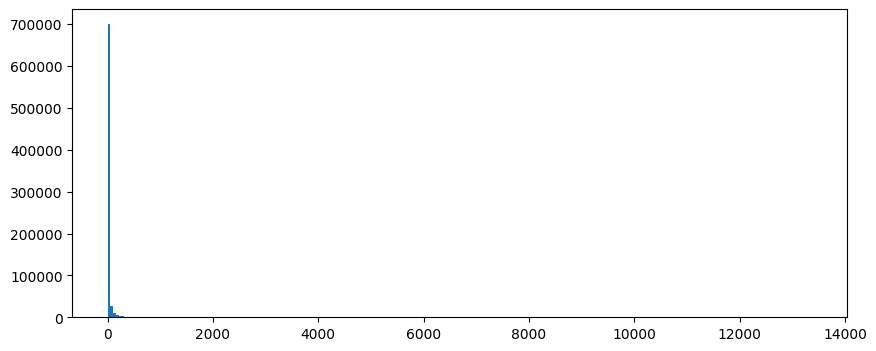

In [6]:
%%time
fig , ax = plt.subplots(figsize = (10 , 4));

freq , bins , patches = ax.hist(twt_df_usr.num_twt , bins = 250);

That's not very enlightening. Let's see if we can do better manually!

CPU times: total: 578 ms
Wall time: 586 ms


Text(0, 0.5, 'log10(number of users)')

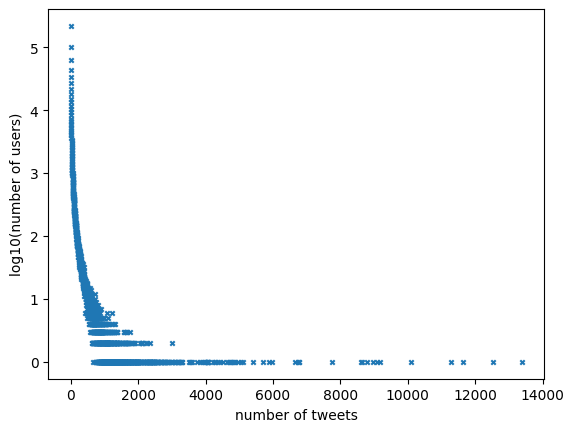

In [7]:
%%time
twt_df_usr_2 = twt_df_usr.groupby('num_twt').agg(users = ('user' , 'nunique')).reset_index()

# Applying log-log transformations on both
twt_df_usr_2['log_users'] = np.log10(twt_df_usr_2['users'])
twt_df_usr_2['log_twt'] = np.log10(twt_df_usr_2['num_twt'])

# Plot
fig , ax = plt.subplots()
ax.scatter(twt_df_usr_2['num_twt'] , twt_df_usr_2['log_users'] , s = 10 , marker = 'x');
ax.set_xlabel('number of tweets');
ax.set_ylabel('log10(number of users)');

We see that this plot roughly agrees with the histogram. It helps us understand that the majority of users tweet between $1$ and $2000$ times (we will return to quantifying this a little later). <br/>
However, there are *some* users who have tweeted over $10,000$ times, with the top user (by volume of tweets) having tweeted $13,376$ times! <br/>
Seeing that there are 30 days in our dataset, this user must have tweeted $\frac{13376}{30 \cdot 24} = 18.6$ times per hour, every hour of every day of the month. This is a bit ludicrous. <br/>

CPU times: total: 15.6 ms
Wall time: 11 ms


(-0.2, 6.0)

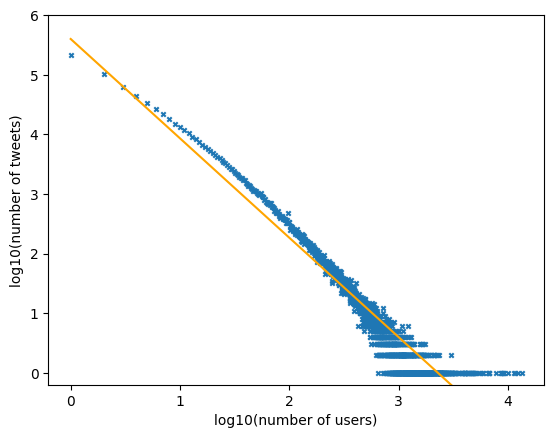

In [8]:
%%time
fig , ax = plt.subplots()
ax.scatter(twt_df_usr_2['log_twt'] , twt_df_usr_2['log_users'] , s = 10 , marker = 'x');
ax.set_xlabel('log10(number of users)');
ax.set_ylabel('log10(number of tweets)');

# Eyeballing the equation of the line
x = np.linspace(0 , 4)
y = (-5/3)*x + 5.6
ax.plot(x , y , color = 'orange')
plt.ylim(-0.2 , 6);

CPU times: total: 109 ms
Wall time: 140 ms


<AxesSubplot: xlabel='log_twt', ylabel='log_users'>

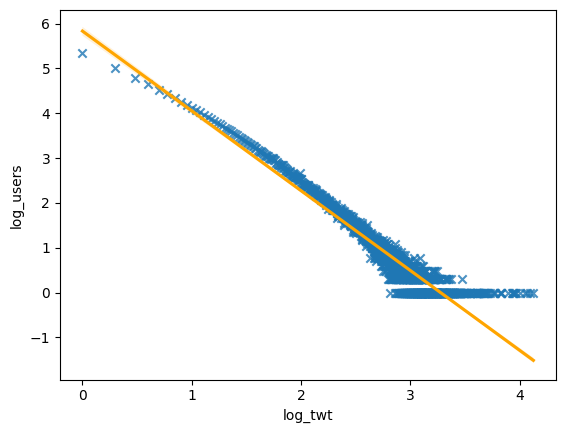

In [9]:
%%time
# Drawback with this is that it doesn't allow us to access the lin reg line!
sns.regplot(
    x = twt_df_usr_2['log_twt'] , y = twt_df_usr_2['log_users'] , 
    scatter = True , 
    fit_reg = True , 
    marker = 'x' , 
    line_kws = {'color' : 'orange'}
)

$$
Y = 5.6 -1.666X
\\
Knowing \ that\ Y = log_{10}y \ and\ X = log_{10}x,
\\
y = 10^{5.6}x^{-1.666}
$$

From this preliminary standpoint, these accounts appear to be bots, but more investigation is needed.

### **Question - 2**

In [10]:
%%time
twt_df_usr.sort_values('num_twt' , ascending=False).head(5)

CPU times: total: 109 ms
Wall time: 101 ms


,user,num_twt
199506,1402775770481713157,13376
267100,1491316688549253120,12518
736010,954732087235563520,11628
188394,1384110594,11294
27730,1069583615762288642,10087


In [24]:
"N\u00e3o basta promover bem a imagem de Portugal - Di\u00e1rio de Not\u00edcias https://t.co/vjRlXRgakr https://t.co/ED9tG9c6XV"

'Não basta promover bem a imagem de Portugal - Diário de Notícias https://t.co/vjRlXRgakr https://t.co/ED9tG9c6XV'

In [29]:
# twt_df[twt_df['user'] == '1384110594'] #L'Hora Catalana - tweets random times e.g.: "It's five minutes to half past eleven in the morning"
# twt_df[twt_df['user'] == '1069583615762288642'] # minijob-anzeigen.de - German Job website - "Automated"
# twt_df[twt_df['user'] == '1402775770481713157'] # crazy halal turkish account!
# twt_df[twt_df['user'] == '1491316688549253120'] # Daily News 79
twt_df[twt_df['user'] == '954732087235563520'].head(4)

,user,ts,tweet_id,hour,day,dayofweek
7036,954732087235563520,2022-06-01 00:26:43,1531779236268236800,0,2,Wed
7059,954732087235563520,2022-06-01 00:26:49,1531779262457565184,0,2,Wed
7093,954732087235563520,2022-06-01 00:26:57,1531779294153801728,0,2,Wed
7121,954732087235563520,2022-06-01 00:27:04,1531779325107765255,0,2,Wed


More investigation is needed to peer into their behaviour. Names, post content and patterns of timestamps may be a good place to start!

In [17]:
%%time

#Create a day dataframe
day_df = pd.DataFrame(
    [
        [0 , 'Mon'],
        [1 , 'Tue'],
        [2 , 'Wed'],
        [3 , 'Thu'],
        [4 , 'Fri'],
        [5 , 'Sat'],
        [6 , 'Sun'],
    ] ,
    columns = ['day' , 'dayofweek']
)

twt_df['hour'] = twt_df['ts'].dt.hour
twt_df['day'] = twt_df['ts'].dt.day_of_week
twt_df = twt_df.merge(day_df , on = 'day' , how = 'inner')

CPU times: total: 3.83 s
Wall time: 3.85 s


In [18]:
def vis_hi_usage(df , users) -> [None]:
    '''
    simple visualization of anomalously voluminous tweeters
    params: df: dataframe; contains user tweets and timestamps
    params: users: list; intended user
    return: no return
    '''
    fig , axes = plt.subplots(len(users) , 1 , figsize = (20, 5))
    for _ , (ax , usr) in enumerate(zip(axes , users)):
        user = str(usr)
        
        df_user = df[df['user'] == user].copy()
        
        df_user['day_hr'] = df_user['day']*100+df_user['hour']
        df_user_2 = df_user.groupby('day_hr').agg(num_tweets = ('tweet_id' , 'nunique')).reset_index()
        df_user_2['day_hr'] = df_user_2['day_hr'].astype('str').str.zfill(4)
        
        ax.plot(df_user_2.day_hr , df_user_2.num_tweets , label = f'User {user}');
        ax.legend(loc = 'right');

CPU times: total: 9.23 s
Wall time: 9.23 s


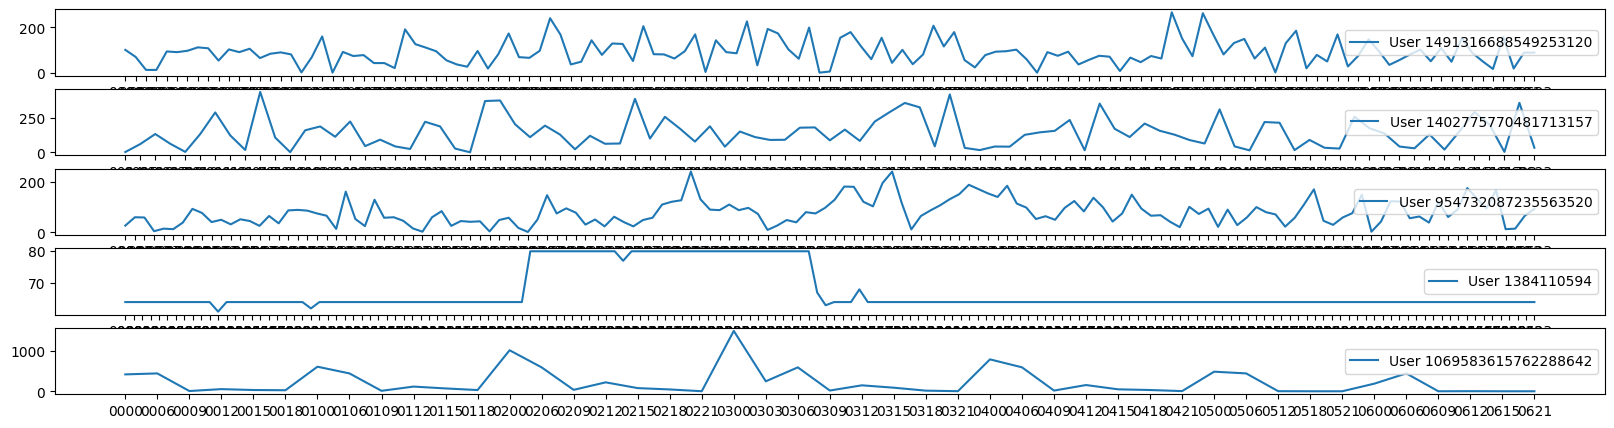

In [19]:
%%time

vis_hi_usage(df = twt_df, users = [1491316688549253120,1402775770481713157,954732087235563520,1384110594,1069583615762288642])

No discernable pattern, apart from maybe 1069583615762288642

### **Question-3**

In [15]:
%%time
# Make DF
twt_mentions_df = pd.DataFrame(
    list(zip(mentions , tweets)) , 
    columns = ['mentions','tweets']
)
# Get rid of null values
twt_mentions_df = twt_mentions_df[twt_mentions_df['tweets']!='None']
# Get rid of duplicates
twt_mentions_df.drop_duplicates(inplace=True)

# Changing from list representation to an actual list
twt_mentions_df['mentions'] = twt_mentions_df['mentions'].apply(lambda x : json.loads(x))
twt_mentions_df = twt_mentions_df.explode('mentions')

CPU times: total: 1min 19s
Wall time: 1min 30s


In [24]:
twt_mentions_df[twt_mentions_df['mentions'] == 118787224].head()

,mentions,tweets
13313,118787224,1531790060017684482
18773,118787224,1531809732519858176
20081,118787224,1531816131744235520
23500,118787224,1531831439964024832
23644,118787224,1531832104908038144


In [18]:
# Grouping to get top 5 users (in terms of number of mentions)
twt_mentions_df_2 = twt_mentions_df[twt_mentions_df['mentions']!="None"].groupby('mentions').agg(num_mentions = ('mentions' , 'count')).reset_index()
twt_mentions_df_2.sort_values('num_mentions', ascending=False).head(5)

,mentions,num_mentions
11617,10228272,22481
200976,68034431,21462
1186956,3131144855,17801
148521,44196397,12487
286159,118787224,10937


*These highly mentioned accounts are probably:*
1. Celebrities/ Influencers
2. Political Figures
3. Companies/ Groups
_____________
**For example**<br/>
10228272 - YouTube<br/>
68034431 - Recep Tayyip Erdogan (President of Turkey)<br/>
3131144855 - BoJo<br/>
44196397 - Elon Musk<br/>
118787224 - Personal account of Working President of TRS
_____________

In [25]:
# %%time

# # Take log-log transform
# twt_mentions_df_3 = twt_mentions_df_2.groupby('num_mentions').agg(users = ('mentions','nunique')).reset_index()
# twt_mentions_df_3['log_users'] = np.log10(twt_mentions_df_3['users'])
# twt_mentions_df_3['log_mentions'] = np.log10(twt_mentions_df_3['num_mentions'])

# # Plot (probably useless since we're not going to do anything with this)
# plt.plot(twt_mentions_df_3['log_users'] , twt_mentions_df_3['log_mentions']);
# plt.xlabel('log users');
# plt.ylabel('log mentions');

### **QUESTION - 4**
Choose 4 countries and compute how often they mention each other. This means you should compute 16 numbers e.g. UK mentions UK, UK mentions
France, France mentions UK etc. Comment on any patterns you observe. [5 marks]

In [4]:
%%time

# Make DF
twt_mentions_df = pd.DataFrame(
    list(zip(user , mentions , tweets , country)) , 
    columns = ['user' , 'mentions' , 'tweet_id' , 'country']
)

twt_mentions_df = twt_mentions_df[twt_mentions_df['tweet_id']!= "None"].drop_duplicates()
# twt_mentions_df = twt_mentions_df[twt_mentions_df['mentions']!= "None"] # Don't remove these now. We may need them for country identification later
print(f'the length of the df is {len(twt_mentions_df)}') # Turn this into an assertion check later!
twt_mentions_df.drop('tweet_id' , axis = 1 , inplace=True)

the length of the df is 15033548
CPU times: total: 42.9 s
Wall time: 43 s


In [5]:
# Changing from list representation to an actual list
twt_mentions_df['mentions'] = twt_mentions_df['mentions'].apply(lambda x : json.loads(x))
twt_mentions_df = twt_mentions_df.explode('mentions')
twt_mentions_df.dropna(inplace = True)
print(f'the length of the df is {len(twt_mentions_df)}') # Turn this into an assertion check later!

the length of the df is 16446394


In [6]:
# Trying to get one primary country per user - the country column is only attached to the user
# Check if primary country adds any value ?
twt_country = twt_mentions_df[['user' ,'country']].drop_duplicates()

twt_mentions_df.drop('country' , axis = 1 , inplace=True)

prim_country = twt_country.groupby(['user','country']).agg(num_occr = ('user','count')).reset_index()

prim_country['max_occr_country'] = prim_country.groupby('user')['num_occr'].rank(method = "first" , ascending = False)
prim_country = prim_country[prim_country['num_occr'] == prim_country['max_occr_country']]

# Use dask to parallelize pandas stuff!
dask_mentions_df = from_pandas(twt_mentions_df, npartitions=8)
# Make data types consistent before joining
dask_mentions_df['user'] = dask_mentions_df['user'].astype('str')
dask_mentions_df['mentions'] = dask_mentions_df['mentions'].astype('str')

dask_user_country_df = from_pandas(prim_country , npartitions=8)

In [7]:
len(dask_mentions_df) , len(dask_user_country_df)

(16446394, 482535)

In [8]:
del twt_mentions_df , 
# del twt_mentions_df_3 , 
# del twt_mentions_df_2 , 
# del twt_df , 
# del day_df , 
# del twt_df_usr , 
# del twt_df_usr_2 , 
del ts_convert , 
del twt_country , 
del prim_country , 
del user , 
del mentions , 
del tweets , 
del country , 
# del ts , 
# del ca ,
# del coord

In [155]:
mentions = dask_mentions_df.merge(
    dask_user_country_df[['user' , 'country']] , on = 'user' , how = 'inner'
    ).merge(
        dask_user_country_df[['user' , 'country']] , left_on = 'mentions' , right_on = 'user' , how = 'inner'
    )
# Quantify the drop - probably because some mentioned accounts have never themselves tweeted anything; hence their country isn't captured 

# See who's mentioning whom?
x_mentions_df = mentions.compute()
x_mentions_df.rename(columns = {'country_x':'user_country' , 'country_y':'mentioned_country'}, inplace = True)
print(f'length = {len(x_mentions_df)}')
x_mentions_df = x_mentions_df[['user_x','user_y','user_country' , 'mentioned_country']]
print(f'length = {len(x_mentions_df)}')

length = 1384252
length = 1384252


In [157]:
# https://www.kaggle.com/datasets/prasertk/country-name-in-different-languages
country_codes = pd.read_csv(
    os.path.join(
        os.getcwd() , 'country name in different languages.csv'
        )
    )

# Let's randomly decide on 4 countries for now.
country_list = ['France' , 'Germany' , 'Spain' , 'Portugal']

# Let's get these countries and the different names they're called by!
restricted_country_names = country_codes[country_codes['en'].isin(country_list)].drop('country_code' , axis = 1)
pivoted_country_names = pd.melt(
    restricted_country_names, id_vars=['en'], var_name='language', value_name='name'
    )[['en' , 'name']].drop_duplicates()

# English names are being left out - add them back in
english_names = [
    ['Germany' , 'Germany'],
    ['France' , 'France'],
    ['Spain' , 'Spain'],
    ['Portugal' , 'Portugal'],
]

english_name_df = pd.DataFrame(english_names , columns = ['en' , 'name'])
pivoted_country_names = pd.concat([pivoted_country_names , english_name_df] , axis = 0).drop_duplicates()

In [158]:
# Names repeated? - Check
t1 = pivoted_country_names.groupby('name').agg('count').sort_values('en' , ascending = False)
print(f'length of duplicates is {len(t1[t1["en"]>1])}') # turn into assertion

length of duplicates is 0


In [168]:
# Changing Non-English names to English names (for consistency)
x_mentions_df_2 = x_mentions_df.merge(
    pivoted_country_names[['en' , 'name']] , 
    left_on = 'user_country' , 
    right_on = 'name',
    how = 'inner'
).merge(
    pivoted_country_names[['en' , 'name']] , 
    left_on = 'mentioned_country' , 
    right_on = 'name',
    how = 'inner'
)

x_mentions_df_2 = x_mentions_df_2[['en_x' , 'en_y']].rename(
    columns = {'en_x':'user_country' , 'en_y':'mentioned_country'}
)[['user_country' , 'mentioned_country']]

# Restricted to 4 countries
print(f'length before grouping : {len(x_mentions_df_2)}')
print(f'sum of occurence : {len(x_mentions_df_2)}')
print("_"*30)

x_mentions_df_3 = x_mentions_df_2.groupby(['user_country' , 'mentioned_country']).agg(occr = ('user_country' , 'count'))

# # Regrouped
print(f'length before grouping : {len(x_mentions_df_3)}')
print(f'sum of occurence : {x_mentions_df_3.sum().occr}')

length before grouping : 339958
sum of occurence : 339958
______________________________
length before grouping : 16
sum of occurence : 339958


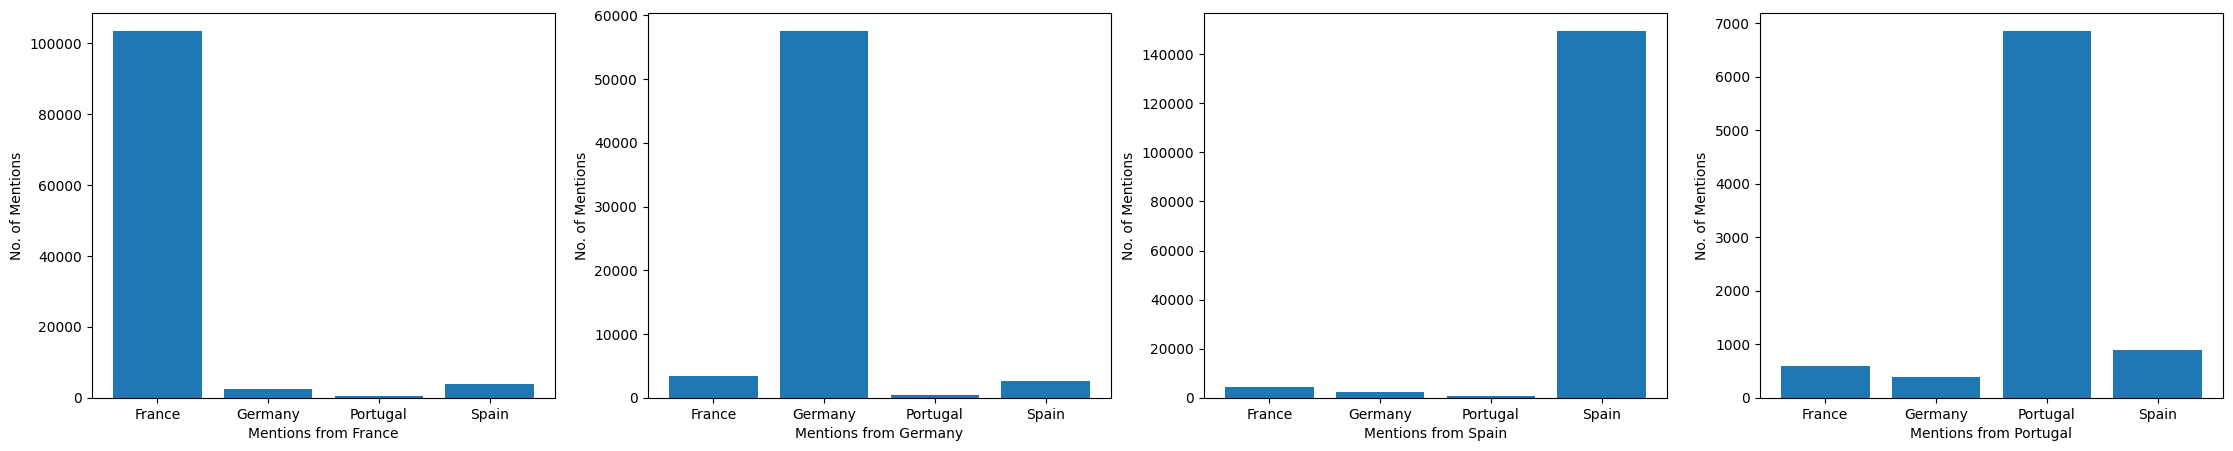

In [173]:
# Graph the number of cross mentions
fig , axes = plt.subplots(1 , len(country_list) , figsize = (27.5 , 5))

for _ , (ax , user) in enumerate(zip(axes , country_list)):
    df = x_mentions_df_3.loc[user]
    ax.bar(df.index , df.occr);
    ax.set_xlabel(f'Mentions from {user}')
    ax.set_ylabel('No. of Mentions');

# Countries seem to mostly be mentioning themselves